In [1]:
import ingestor, modeller, fitter
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

In [3]:
from importlib import reload
reload(ingestor)
reload(modeller)
reload(fitter)

<module 'fitter' from '/media/dwu402/Data/wrap-mad/fitter.py'>

In [4]:
plt.style.use('seaborn-notebook')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

from cycler import cycler

new_color = cycler(color=["k"])
plt.rcParams['axes.prop_cycle'] = plt.rcParams['axes.prop_cycle'].concat(new_color)

In [5]:
context = ingestor.Context("runs/augmented_all.run")

In [6]:
def replace(l, idx, val):
    return l[:idx] + [val] + l[idx+1:]

In [7]:
solvers = []

In [8]:
Nalpha = 49
Nrho = 49
alphas = np.logspace(-7, 5, num=Nalpha)
rhos = np.logspace(-6, 6, num=Nrho)

In [9]:
for alpha in alphas:
    print(f"alpha : {alpha}")
    context.update('fitting_configuration', 
                   {'regularisation_parameter': replace(context.fitting_configuration['regularisation_parameter'], 
                                                        2, alpha)
                   })
    solver = fitter.Fitter(context)
    solvers.append(solver)
    for rho in rhos:
        solver.solve(rho)
        solver.problems[0].initial_guess = solver.solutions[str(rho)][-1].x

alpha : 1e-07
alpha : 1.7782794100389227e-07
alpha : 3.162277660168379e-07
alpha : 5.62341325190349e-07
alpha : 1e-06
alpha : 1.778279410038923e-06
alpha : 3.162277660168379e-06
alpha : 5.623413251903491e-06
alpha : 1e-05
alpha : 1.778279410038923e-05
alpha : 3.1622776601683795e-05
alpha : 5.623413251903491e-05
alpha : 0.0001
alpha : 0.00017782794100389227
alpha : 0.00031622776601683794
alpha : 0.0005623413251903491
alpha : 0.001
alpha : 0.0017782794100389228
alpha : 0.0031622776601683794
alpha : 0.005623413251903491
alpha : 0.01
alpha : 0.01778279410038923
alpha : 0.03162277660168379
alpha : 0.05623413251903491
alpha : 0.1
alpha : 0.1778279410038923
alpha : 0.31622776601683794
alpha : 0.5623413251903491
alpha : 1.0
alpha : 1.7782794100389228
alpha : 3.1622776601683795
alpha : 5.623413251903491
alpha : 10.0
alpha : 17.78279410038923
alpha : 31.622776601683793
alpha : 56.23413251903491
alpha : 100.0
alpha : 177.82794100389228
alpha : 316.22776601683796
alpha : 562.341325190349
alpha : 1

## Visualisations

In [39]:
funs = [list(map(lambda x: x[0]['fun'], solver.solutions.values())) for solver in solvers]
sols = [solver.solutions for solver in solvers]

rs = []
fs = []
ds = []

for alpha, solver, sol, fun in zip(alphas, solvers, sols, funs):
    rs.append([solver.regularisation(sol[str(rho)][0].x)/alpha  for rho in rhos])
    fs.append([fun[idx] - solver.regularisation(sol[str(rho)][0].x) for idx, _ in enumerate(rhos)])
    ds.append([(solver.problems[0].cache.results[fitter.tokey(rho, sol[str(rho)][0].x)].fun - fs[-1][idx])/rho 
               for idx, rho in enumerate(rhos)])


In [40]:
fs, rs, ds = (np.array(fs), np.array(rs), np.array(ds))

<IPython.core.display.Javascript object>


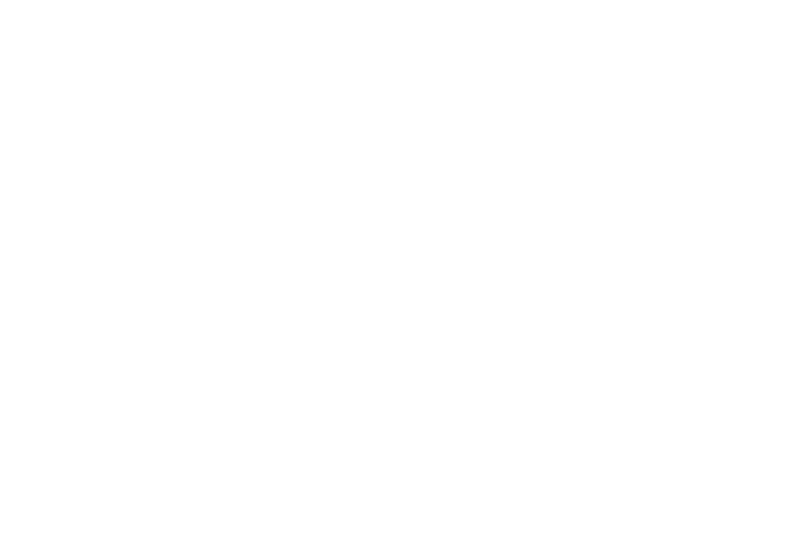

/home/dwu402/.virtualenvs/scider/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/home/dwu402/.virtualenvs/scider/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/home/dwu402/.virtualenvs/scider/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/dwu402/.virtualenvs/scider/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


Text(0.5, 0, 'Gradient Field')

In [45]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.contourf(np.log10(fs), np.log10(rs), np.log10(abs(ds)), levels=50)
ax.plot_wireframe(np.log10(fs), np.log10(rs), np.log10(abs(ds)), linewidth=0.25)
# ax.scatter(np.log10(fs), np.log10(rs), np.log10(abs(ds)), s=5)
ax.set_xlabel('Data Fit')
ax.set_ylabel('Outer Regularisation Term')
ax.set_zlabel('Gradient Field')

<IPython.core.display.Javascript object>


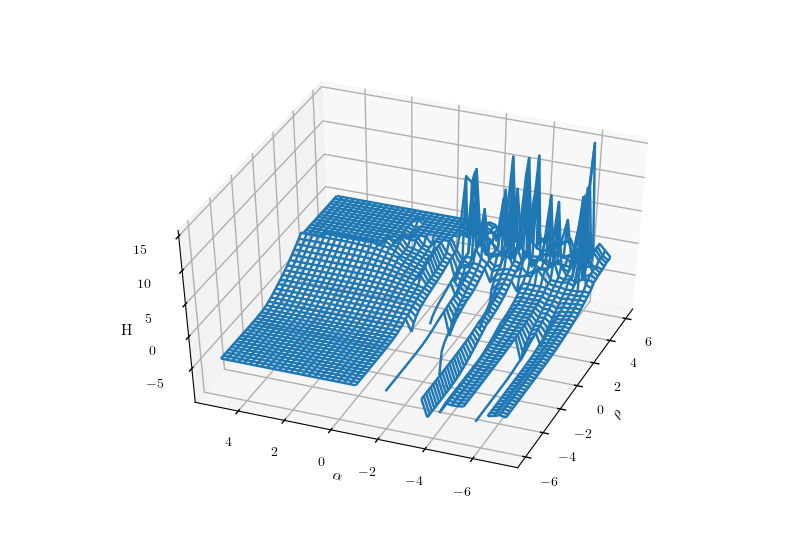

/home/dwu402/.virtualenvs/scider/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 0, 'H')

In [46]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(*np.log10(np.meshgrid(rhos,alphas)), np.log(fs))
ax.set_xlabel(r"$\rho$")
ax.set_ylabel(r"$\alpha$")
ax.set_zlabel("H")

<IPython.core.display.Javascript object>


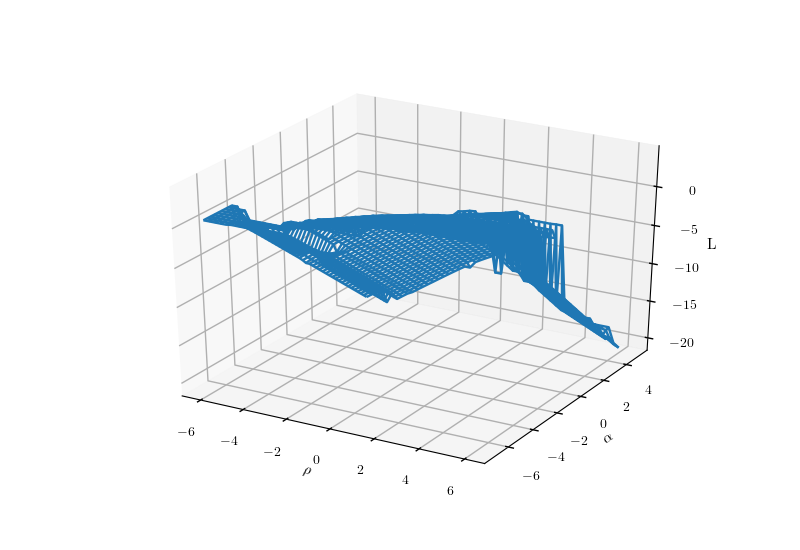

Text(0.5, 0, 'L')

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(*np.log10(np.meshgrid(rhos,alphas)), np.log10(rs))
ax.set_xlabel(r"$\rho$")
ax.set_ylabel(r"$\alpha$")
ax.set_zlabel("L")

In [15]:
#little tweak
ds[ds==0] = -(10**(np.min(np.log10(np.abs(ds[ds!=0])))-0.1))

<IPython.core.display.Javascript object>


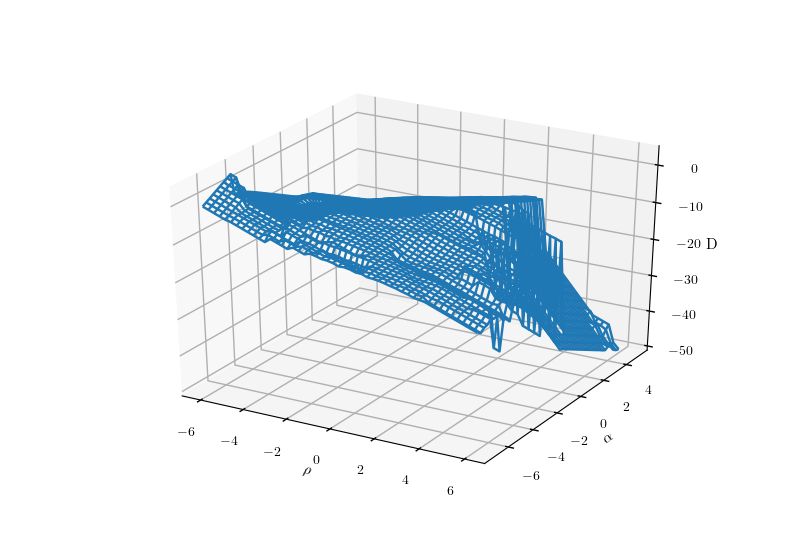

Text(0.5, 0, 'D')

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(*np.log10(np.meshgrid(rhos,alphas)), np.log(np.abs(ds)))
ax.set_xlabel(r"$\rho$")
ax.set_ylabel(r"$\alpha$")
ax.set_zlabel("D")

In [17]:
from scipy import interpolate

rhomesh, alphamesh= np.log10(np.meshgrid(rhos,alphas))

In [18]:
fs_smooth = interpolate.RectBivariateSpline(np.log10(alphas), np.log10(rhos), np.log10(fs), kx=4, ky=4, s=600)
rs_smooth = interpolate.RectBivariateSpline(np.log10(alphas), np.log10(rhos), np.log10(rs), kx=4, ky=4, s=600)
ds_smooth = interpolate.RectBivariateSpline(np.log10(alphas), np.log10(rhos), np.log10(np.abs(ds)), kx=4, ky=4, s=600)

<IPython.core.display.Javascript object>


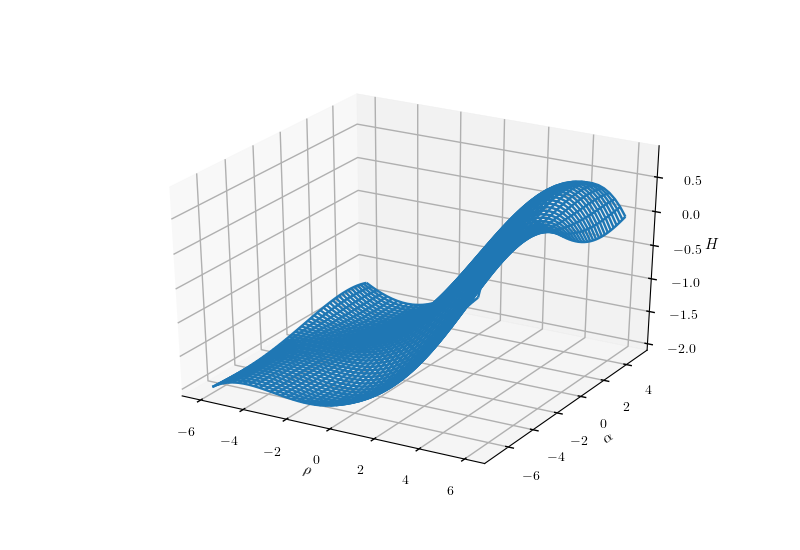

Text(0.5, 0, '$H$')

In [19]:
fs_eval = np.array([fs_smooth(a, r).item() for r,a in zip(rhomesh.flatten(), alphamesh.flatten())]).reshape(Nalpha, Nrho)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(rhomesh, alphamesh, fs_eval)
ax.set_xlabel(r"$\rho$")
ax.set_ylabel(r"$\alpha$")
ax.set_zlabel(r"$H$")

<IPython.core.display.Javascript object>


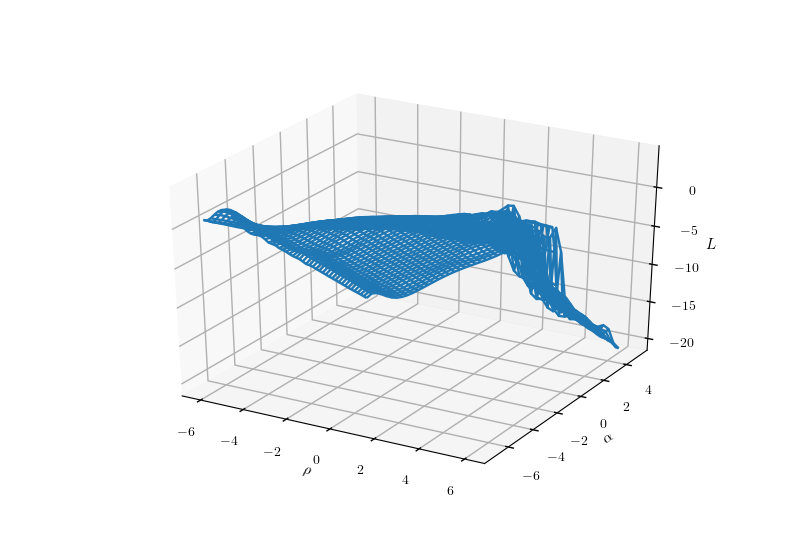

Text(0.5, 0, '$L$')

In [20]:
rs_eval = np.array([rs_smooth(a, r).item() for r,a in zip(rhomesh.flatten(), alphamesh.flatten())]).reshape(Nalpha, Nrho)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(rhomesh, alphamesh, rs_eval)
ax.set_xlabel(r"$\rho$")
ax.set_ylabel(r"$\alpha$")
ax.set_zlabel(r"$L$")

<IPython.core.display.Javascript object>


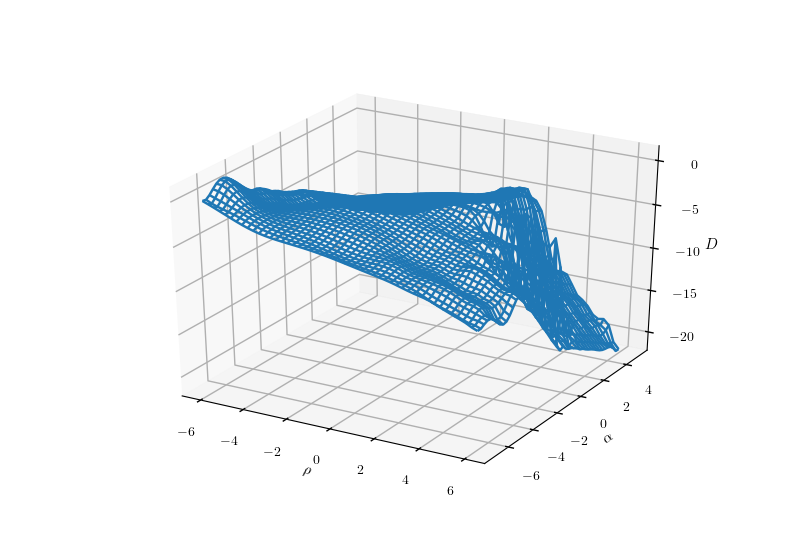

Text(0.5, 0, '$D$')

In [21]:
ds_eval = np.array([ds_smooth(a, r).item() for r,a in zip(rhomesh.flatten(), alphamesh.flatten())]).reshape(Nalpha, Nrho)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(rhomesh, alphamesh, ds_eval)
ax.set_xlabel(r"$\rho$")
ax.set_ylabel(r"$\alpha$")
ax.set_zlabel(r"$D$")

<IPython.core.display.Javascript object>


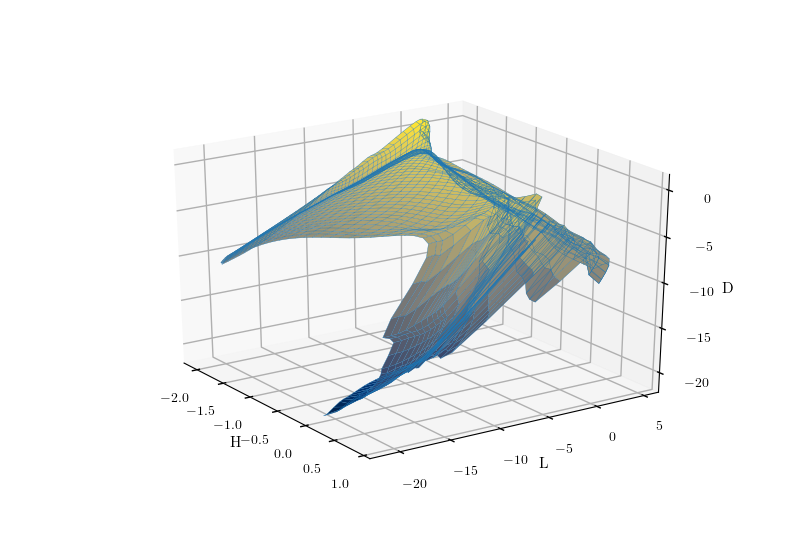

Text(0.5, 0, 'D')

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(fs_eval, rs_eval, ds_eval, cmap='cividis')
ax.plot_wireframe(fs_eval, rs_eval, ds_eval, linewidth=0.25)
ax.set_xlabel('H')
ax.set_ylabel('L')
ax.set_zlabel('D')

In [23]:
x_u = lambda r, a: np.array([f(a, r, dx=1).item() for f in [fs_smooth, rs_smooth, ds_smooth]])
x_v = lambda r, a: np.array([f(a, r, dy=1).item() for f in [fs_smooth, rs_smooth, ds_smooth]])
x_uu = lambda r, a: np.array([f(a, r, dx=2).item() for f in [fs_smooth, rs_smooth, ds_smooth]])
x_uv = lambda r, a: np.array([f(a, r, dx=1, dy=2).item() for f in [fs_smooth, rs_smooth, ds_smooth]])
x_vv = lambda r, a: np.array([f(a, r, dy=2).item() for f in [fs_smooth, rs_smooth, ds_smooth]])
n = lambda r, a: np.cross(x_u(r,a), x_v(r,a))/np.linalg.norm(np.cross(x_u(r,a), x_v(r,a)))

fundamental_1 = lambda r, a: np.array([[np.dot(x_u(r,a), x_u(r,a)), np.dot(x_u(r,a), x_v(r,a))],
                                       [np.dot(x_u(r,a), x_v(r,a)), np.dot(x_v(r,a), x_v(r,a))]])
fundamental_2 = lambda r, a: np.array([[np.dot(x_uu(r,a), n(r,a)), np.dot(x_uv(r,a), n(r,a))],
                                       [np.dot(x_uv(r,a), n(r,a)), np.dot(x_vv(r,a), n(r,a))]])

curvature = lambda r, a: np.linalg.eigvals(np.linalg.solve(fundamental_1(r,a), fundamental_2(r,a)))
gaussian_curvature = lambda r, a: np.prod(curvature(r,a))
mean_curvature = lambda r, a: np.mean(curvature(r, a))

In [24]:
gcurvs = np.array([gaussian_curvature(r, a) for r, a in zip(rhomesh.flatten(), alphamesh.flatten())]).reshape(Nalpha, Nrho)
mcurvs = np.array([mean_curvature(r, a) for r, a in zip(rhomesh.flatten(), alphamesh.flatten())]).reshape(Nalpha, Nrho)

<IPython.core.display.Javascript object>


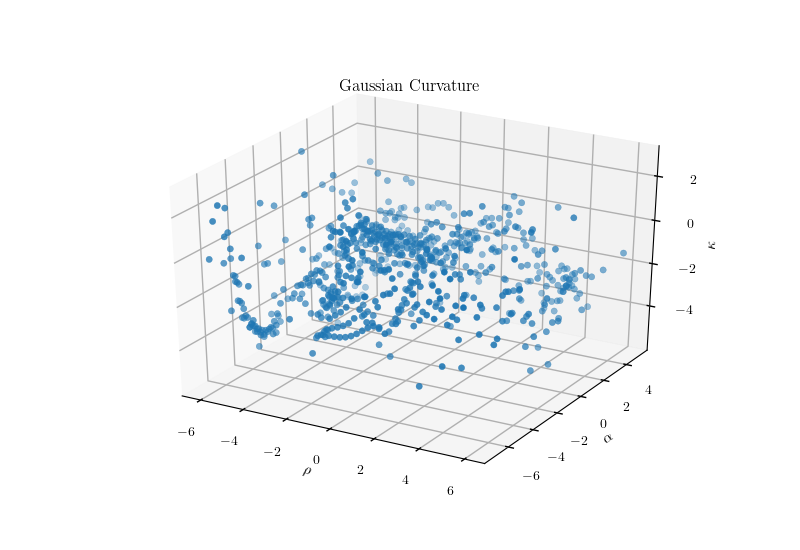

/home/dwu402/.virtualenvs/scider/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 0.92, 'Gaussian Curvature')

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(rhomesh, alphamesh, np.log10(gcurvs))
ax.set_xlabel(r"$\rho$")
ax.set_ylabel(r"$\alpha$")
ax.set_zlabel(r"$\kappa$")
ax.set_title("Gaussian Curvature")

<IPython.core.display.Javascript object>


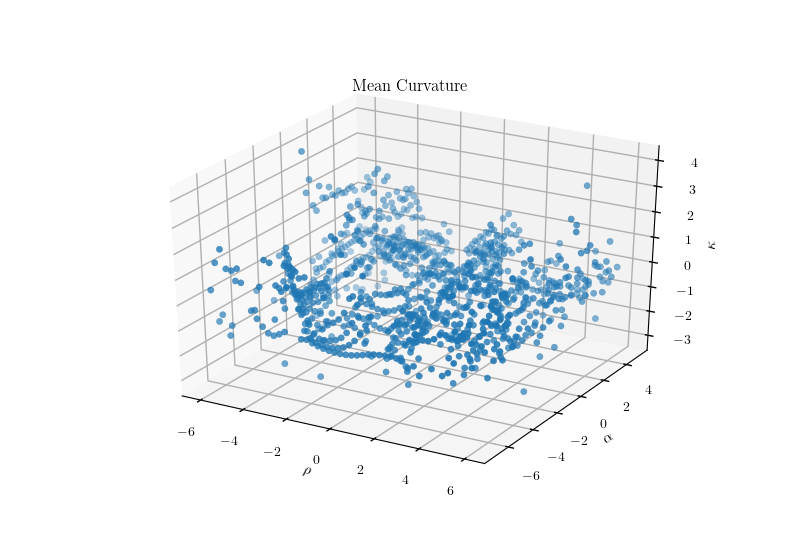

/home/dwu402/.virtualenvs/scider/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 0.92, 'Mean Curvature')

In [26]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(rhomesh, alphamesh, np.log10(mcurvs))
ax.set_xlabel(r"$\rho$")
ax.set_ylabel(r"$\alpha$")
ax.set_zlabel(r"$\kappa$")
ax.set_title("Mean Curvature")

<IPython.core.display.Javascript object>


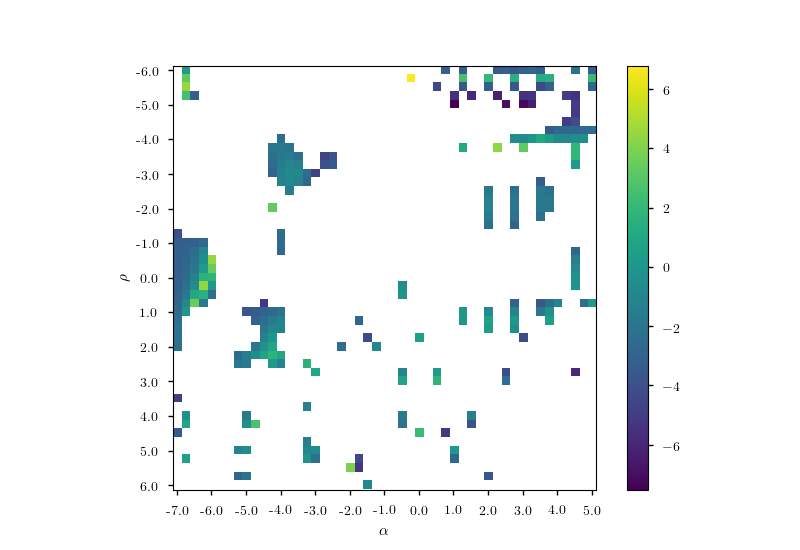

/home/dwu402/.virtualenvs/scider/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


In [27]:
fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.imshow(np.log10(gcurvs).T + np.log10(mcurvs).T)
ax.set_xticks(range(0, Nalpha, 4))
ax.set_xticklabels(np.log10(alphas[::4]))
ax.set_yticks(range(0, Nrho, 4))
ax.set_yticklabels(np.round(np.log10(rhos[::4]), 2))
ax.set_xlabel(r"$\alpha$")
ax.set_ylabel(r"$\rho$")
fig.colorbar(im)

<IPython.core.display.Javascript object>


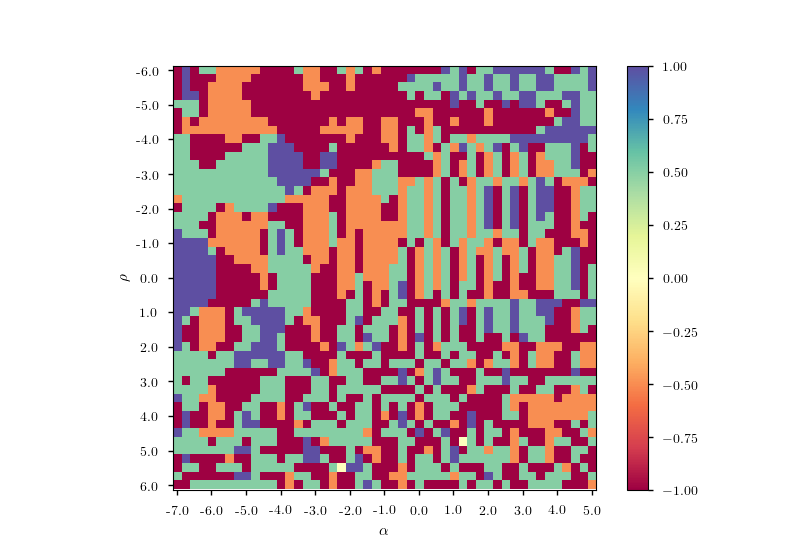

In [28]:
def ctfn(mk, gk):
    tol = 1e-6
    if mk > tol:
        if gk > tol:
            return 1
        elif gk < -tol:
            return 0.5
    elif mk < -tol:
        if gk > tol:
            return -0.5
        elif gk <-tol:
            return -1
    return 0

curv_type = np.array([ctfn(M,G) for M, G in zip(mcurvs.flatten(), gcurvs.flatten())]).reshape(mcurvs.shape)

fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.imshow(curv_type.T, cmap='Spectral')
ax.set_xticks(range(0, Nalpha, 4))
ax.set_xticklabels(np.log10(alphas[::4]))
ax.set_yticks(range(0, Nrho, 4))
ax.set_yticklabels(np.round(np.log10(rhos[::4]), 2))
ax.set_xlabel(r"$\alpha$")
ax.set_ylabel(r"$\rho$")
fig.colorbar(im)

In [29]:
fs

array([[0.01235776, 0.01235837, 0.01235946, ..., 0.28207222, 0.27581046,
        0.29038331],
       [0.01235817, 0.01235878, 0.01235986, ..., 0.50516328, 0.45549918,
        0.70548432],
       [0.01235889, 0.0123595 , 0.01236059, ..., 1.6378466 , 1.63772304,
        1.637719  ],
       ...,
       [0.01235792, 0.01235906, 0.01236108, ..., 1.632687  , 1.63268996,
        1.63269162],
       [0.01235792, 0.01235906, 0.01236108, ..., 1.632687  , 1.63268996,
        1.63269162],
       [0.01235792, 0.01235906, 0.01236108, ..., 1.632687  , 1.63268996,
        1.63269162]])

In [30]:
rs

array([[5.23326986e+00, 5.23326905e+00, 5.23326926e+00, ...,
        4.04504779e+04, 4.04345963e+04, 4.04109877e+04],
       [5.23326823e+00, 5.23326580e+00, 5.23326437e+00, ...,
        1.25392974e+04, 1.25391935e+04, 1.25391935e+04],
       [5.23326533e+00, 5.23326000e+00, 5.23325568e+00, ...,
        1.62947311e+04, 1.58908519e+04, 1.58907033e+04],
       ...,
       [9.91722278e-21, 3.13610211e-20, 9.91721688e-20, ...,
        1.08693891e-19, 3.43745470e-20, 1.08708459e-20],
       [3.13610205e-21, 9.91722278e-21, 3.13610211e-20, ...,
        2.43491487e-19, 1.08702018e-20, 3.43766367e-21],
       [9.91716960e-22, 3.13610205e-21, 9.91722278e-21, ...,
        3.43136987e-19, 3.43746016e-21, 1.08708429e-21]])

In [31]:
ds

array([[-5.23326986e-01, -2.94288345e-01, -1.65490505e-01, ...,
        -1.27915643e-08, -7.19040101e-09, -4.04109877e-09],
       [-9.30621313e-01, -5.23326580e-01, -2.94288082e-01, ...,
        -7.05136513e-09, -3.96524114e-09, -2.22981896e-09],
       [-1.65490380e+00, -9.30619851e-01, -5.23325568e-01, ...,
        -1.62947311e-08, -8.93608273e-09, -5.02508162e-09],
       ...,
       [-3.13984949e-10, -5.57989831e-10, -9.91810455e-10, ...,
        -1.05325004e-20, -1.97428675e-21, -4.44089210e-22],
       [-1.76941795e-10, -3.13137650e-10, -5.57893381e-10, ...,
        -4.35343350e-20, -1.18457205e-21, -2.22044605e-22],
       [-9.88792381e-11, -1.76566712e-10, -3.13780741e-10, ...,
        -1.08835838e-19, -7.89714698e-22, -1.76376299e-22]])

In [32]:
i = np.argmax(mcurvs)
print(10**rhomesh.flatten()[i])
print(10**alphamesh.flatten()[i])

1.778279410038923e-06
0.5623413251903491


<IPython.core.display.Javascript object>


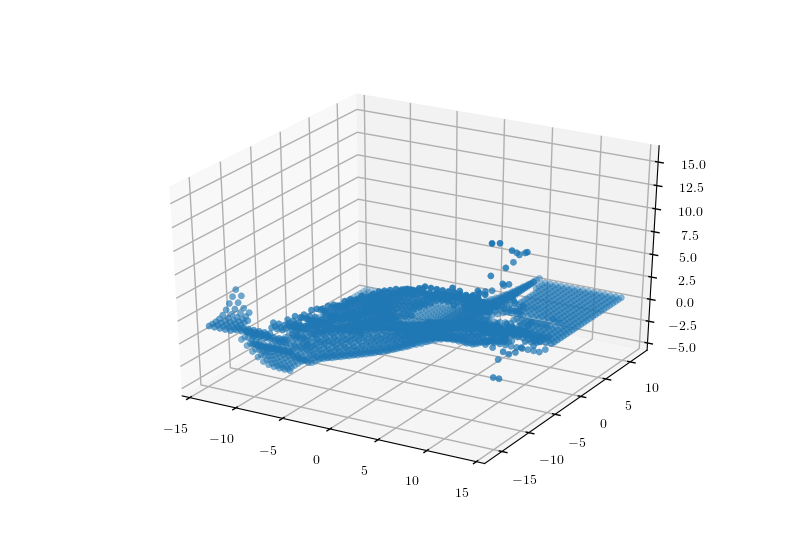

In [33]:
# norm calcs
error_norms = []
for f, d, r in zip(fs, ds, rs):
    error_norms.append([np.linalg.norm([fi,di,ri]) for fi,di,ri in zip(f,d,r)])
    
error_norms = np.array(error_norms)
    
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(*np.log(np.meshgrid(rhos,alphas)), np.log(error_norms))

In [34]:
np.argmin(error_norms)

1960

<IPython.core.display.Javascript object>


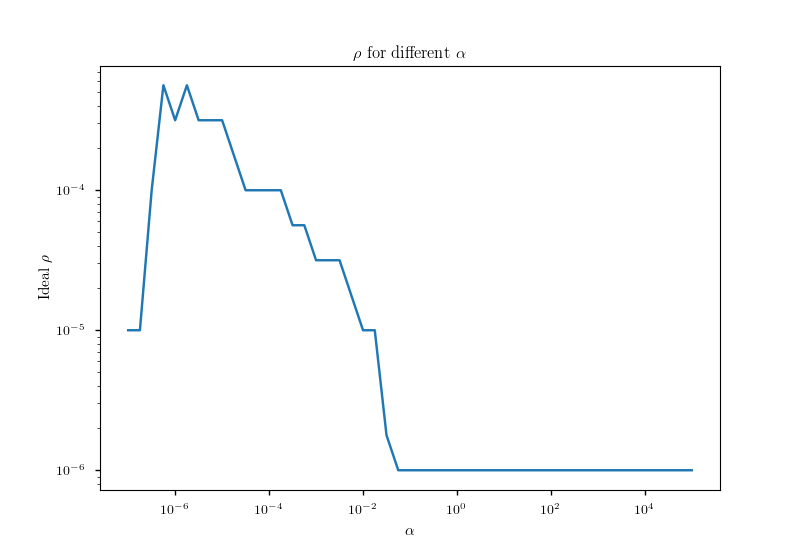

Text(0, 0.5, 'Ideal $\\rho$')

In [35]:
# Perform a profiling step
ideal_rhos = []
jdxs = []
for alpha, en in zip(alphas, error_norms):
    jdxs.append(np.argmin(en))
    ideal_rhos.append((rhos[np.argmin(en)], min(en)))
ideal_rhos = np.array(ideal_rhos)
plt.figure()
plt.loglog(alphas, ideal_rhos[:,0])
plt.title(r"$\rho$ for different $\alpha$")
plt.xlabel("$\\alpha$")
plt.ylabel("Ideal $\\rho$")

<IPython.core.display.Javascript object>


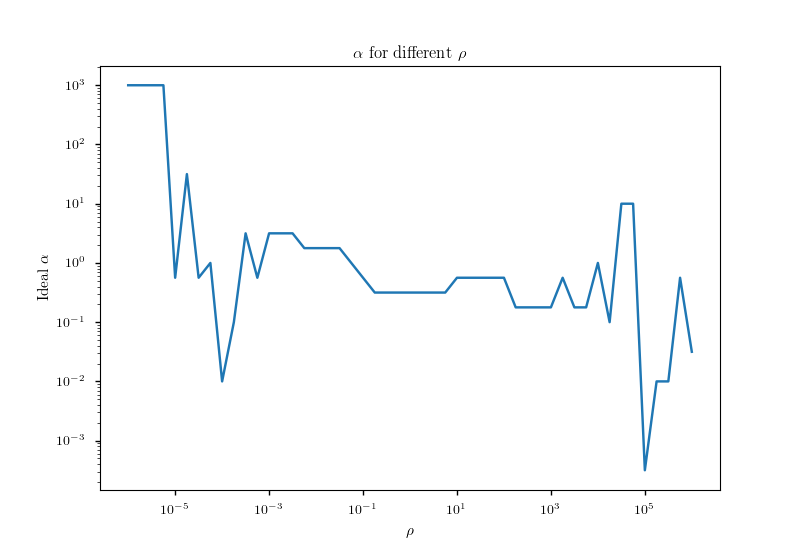

Text(0, 0.5, 'Ideal $\\alpha$')

In [36]:
# Transpose profiling

ideal_alphas = []
kdxs = []
for rho, en in zip(rhos, error_norms.T):
    kdxs.append(np.argmin(en))
    ideal_alphas.append((alphas[np.argmin(en)], min(en)))
ideal_alphas = np.array(ideal_alphas)
plt.figure()
plt.loglog(rhos, ideal_alphas[:,0])
plt.title(r"$\alpha$ for different $\rho$")
plt.xlabel("$\\rho$")
plt.ylabel("Ideal $\\alpha$")

<IPython.core.display.Javascript object>


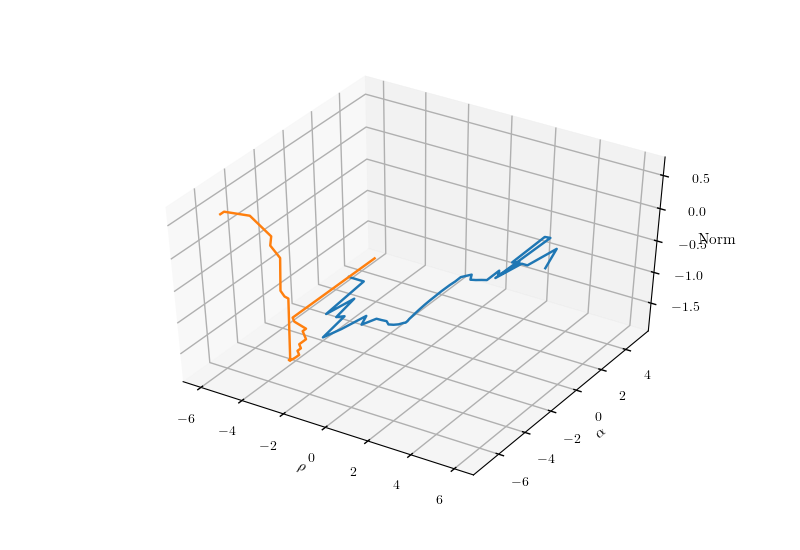

Text(0.5, 0, 'Norm')

In [37]:
# construct contraction mapping plot
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.plot(*np.log10((rhos, ideal_alphas[:,0], ideal_alphas[:,1])))
ax.plot(*np.log10((ideal_rhos[:,0], alphas, ideal_rhos[:,1])))
ax.set_xlabel(r"$\rho$")
ax.set_ylabel(r"$\alpha$")
ax.set_zlabel("Norm")

<IPython.core.display.Javascript object>


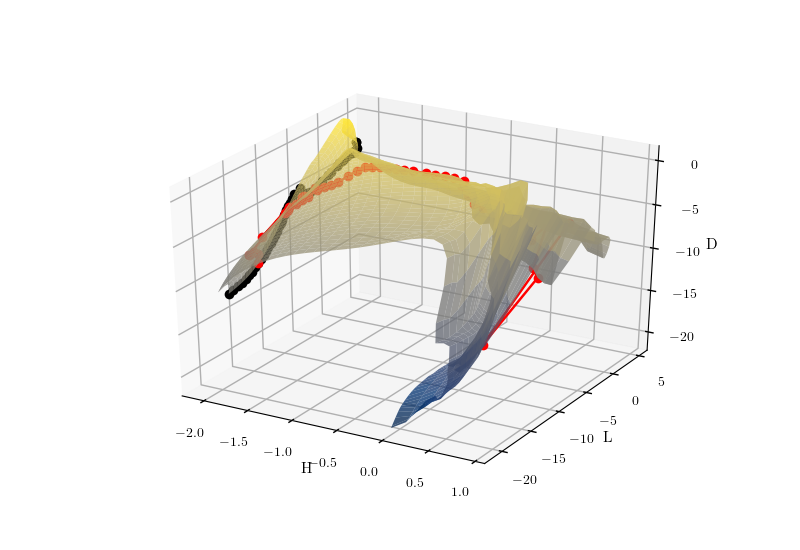

Text(0.5, 0, 'D')

In [38]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(fs_eval, rs_eval, ds_eval, cmap='cividis', alpha=0.75)
# ax.plot_wireframe(fs_eval, rs_eval, ds_eval, linewidth=0.25)

# plot in points
ax.plot(fs_eval[range(Nalpha), jdxs], rs_eval[range(Nalpha), jdxs], ds_eval[range(Nalpha), jdxs], 'ko-')
ax.plot(fs_eval[kdxs, range(Nrho)], rs_eval[kdxs, range(Nrho)], ds_eval[kdxs, range(Nrho)], 'ro-')

ax.set_xlabel('H')
ax.set_ylabel('L')
ax.set_zlabel('D')